# Implenetation of a Variational Autoencoder

A simple implementation of a VAE on the following dataset:
* https://www.kaggle.com/mloey1/covid19-chest-ct-image-augmentation-gan-dataset

Purpose is to examine and compare results to the generated data from the following paper, where they used a CGAN to improve classification results:
* https://link.springer.com/article/10.1007%2Fs00521-020-05437-x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import copy

## Hyperparameter settings and data loading

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# hyperparameter settings #######################
# latent = number of latent dimensions
# nE = number of epochs
# bs = batch size
# cap = capacity of network
# lr = learning rate of optimizer
# wd = weight decay
# vb = variational beta
runs = [
    # {"latent":2, "nE":100, "bs":128, "cap":64, "lr":1e-3, "wd":1e-5, "vb":1} # batch 1
    # ,{"latent":6, "nE":100, "bs":128, "cap":64, "lr":1e-3, "wd":1e-5, "vb":1} # batch 1
    # ,{"latent":10, "nE":100, "bs":128, "cap":64, "lr":1e-3, "wd":1e-5, "vb":1} # batch 1
    # ,{"latent":20, "nE":100, "bs":128, "cap":64, "lr":1e-3, "wd":1e-5, "vb":1} # batch 1
    {"latent":20, "nE":100, "bs":64, "cap":64, "lr":1e-3, "wd":1e-5, "vb":1}
    ,{"latent":20, "nE":200, "bs":64, "cap":64, "lr":1e-3, "wd":1e-5, "vb":1}
    ,{"latent":20, "nE":100, "bs":64, "cap":64, "lr":1e-3, "wd":1e-5, "vb":0.5}
    ,{"latent":20, "nE":200, "bs":64, "cap":64, "lr":1e-3, "wd":1e-5, "vb":0.5}
        ]

train_dir='/content/drive/MyDrive/COVID 19 DATASET/COVID-19/COVID-19/train'

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([transforms.Resize( (256,256)) ,
        transforms.ToTensor(),
    ]))

In [ ]:

def show_image(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def plot_loss(training_loss, settings):
    fig, ax = plt.subplots()
    ax.plot(range(len(training_loss)), training_loss)

    ax.set(xlabel='epochs', ylabel='BCE loss')
    ax.set_title(f'Loss for {settings}', y=1.1)
    ax.grid()

    fig.savefig("test.png")
    plt.show()

## Setting up VAE architecture

In [ ]:
class Encoder(nn.Module):
    '''encoder for VAE, goes from image conv net to linear latent layer'''
    def __init__(self, capacity, latent_dims):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = c, kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = c, out_channels = c*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = c*2, out_channels = c*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = c*2*2, out_channels = c*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = c*2*2*2, out_channels = c*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv6 = nn.Conv2d(in_channels = c*2*2*2*2, out_channels = c*2*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.fc_mu = nn.Linear(in_features = 32768, out_features = latent_dims)
        self.fc_logvar = nn.Linear(in_features = 32768, out_features = latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(x.size(0), -1) # flatten feature maps to feature vectors for linear layers
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    '''decoder for VAE, goes from linear latent layer to deconv layers to reconstruct image'''
    def __init__(self, capacity, latent_dims):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features = latent_dims, out_features = 32768)
        self.conv1 = nn.ConvTranspose2d(in_channels = c, out_channels = 3, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(out_channels = c, in_channels = c*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv3 = nn.ConvTranspose2d(out_channels = c*2, in_channels = c*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv4 = nn.ConvTranspose2d(out_channels = c*2*2, in_channels = c*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv5 = nn.ConvTranspose2d(out_channels = c*2*2*2, in_channels = c*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)
        self.conv6 = nn.ConvTranspose2d(out_channels = c*2*2*2*2, in_channels = c*2*2*2*2*2, kernel_size = 4, stride = 2, padding = 1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 2048, 4, 4) # unflatten feature vectors to feature maps for conv layers
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # using BCE (Binary Crossentropy) as reconstruction loss, so output is sigmoid
        return x

class VAE(nn.Module):
    '''VAE architecture for encoder -> sample from latent -> decode latent sample'''
    def __init__(self, capacity, latent_dims):
        super(VAE, self).__init__()
        self.encoder = Encoder(capacity, latent_dims)
        self.decoder = Decoder(capacity, latent_dims)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar) # sample an image from latent distribution
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparamterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar, variational_beta): # pass variational beta
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 65536), x.view(-1, 65536), reduction = 'sum')

    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

## setting up functions for training

In [ ]:
def setup_model(capacity, latent_dims):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    vae = VAE(capacity = capacity, latent_dims = latent_dims).to(device)
    print(vae)

    return vae

In [ ]:
def train(vae, train_loader, n_epochs, learning_rate, weight_decay, variational_beta):

    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)


    # set to training mode
    vae.train()

    train_loss = []
    best_model_wts = None
    bmw_epoch = 0


    print('Training ...')
    for epoch in tqdm(range(n_epochs)):

        num_batches = 0
        avg_loss = 0
        best_loss = 0

        image_batch_recon = None

        for image_batch, _ in train_loader:

            image_batch = image_batch.to(device)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar, variational_beta)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            avg_loss += loss.item()
            num_batches += 1

        if epoch % (n_epochs//10) == 0 and epoch != 0:
            show_image(image_batch_recon)
        avg_loss /= num_batches
        train_loss.append(avg_loss)

        ## best weight
        if epoch == 0:
            best_loss = avg_loss
            best_model_wts = copy.deepcopy(vae.state_dict())
        if avg_loss < best_loss:
            best_model_wts = copy.deepcopy(vae.state_dict())
            best_loss = avg_loss
            bmw_epoch = epoch + 1

    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, n_epochs, sum(train_loss)/len(train_loss)))
    return vae, best_model_wts, bmw_epoch, train_loss

## training model

starting run ... 0/4
{'latent': 20, 'nE': 100, 'bs': 64, 'cap': 64, 'lr': 0.001, 'wd': 1e-05, 'vb': 1}
cuda
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=32768, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=32768, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=20, out_features=32768, bias=True)
    (conv1): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=

 10%|█         | 10/100 [02:22<09:44,  6.50s/it]

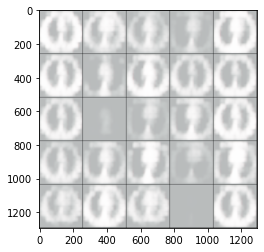

 20%|██        | 20/100 [03:17<07:14,  5.43s/it]

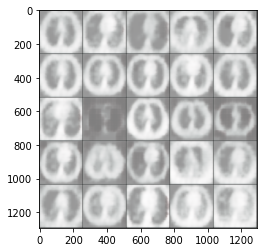

 30%|███       | 30/100 [04:11<06:18,  5.41s/it]

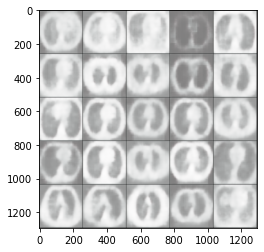

 40%|████      | 40/100 [05:05<05:22,  5.37s/it]

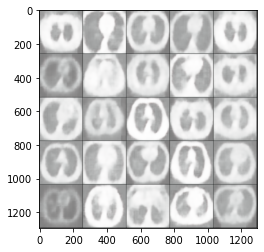

 50%|█████     | 50/100 [06:00<04:30,  5.41s/it]

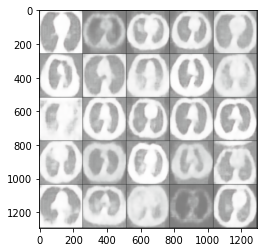

 60%|██████    | 60/100 [06:54<03:34,  5.37s/it]

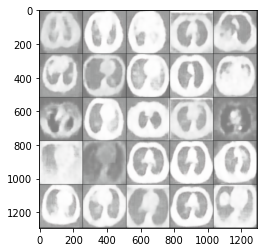

 70%|███████   | 70/100 [07:49<02:42,  5.42s/it]

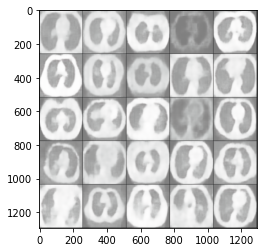

 80%|████████  | 80/100 [08:43<01:48,  5.41s/it]

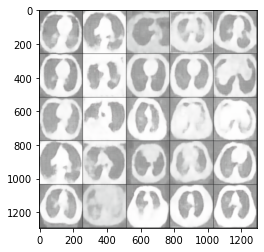

 90%|█████████ | 90/100 [09:38<00:54,  5.43s/it]

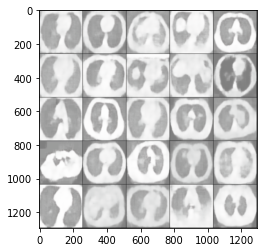

100%|██████████| 100/100 [10:32<00:00,  6.33s/it]

Epoch [100 / 100] average reconstruction error: 8168160.202143


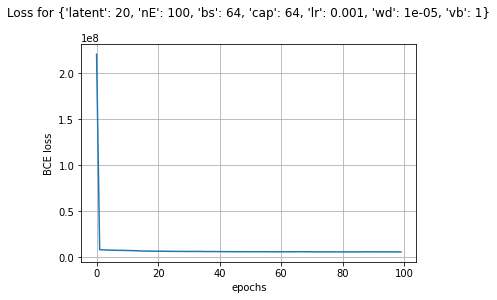

-------------------------------------------------------------------
saving weights for model
-------------------------------------------------------------------

starting run ... 1/4
{'latent': 20, 'nE': 200, 'bs': 64, 'cap': 64, 'lr': 0.001, 'wd': 1e-05, 'vb': 1}
cuda
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=32768, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=32768, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=20, out_features=32768, b

 10%|█         | 20/200 [01:48<16:19,  5.44s/it]

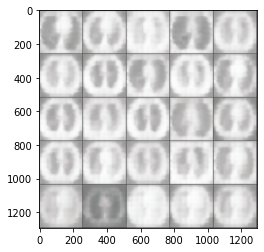

 20%|██        | 40/200 [03:37<14:27,  5.42s/it]

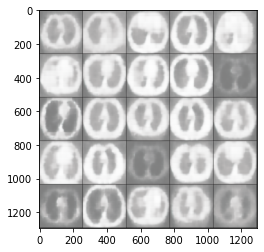

 30%|███       | 60/200 [05:26<12:36,  5.41s/it]

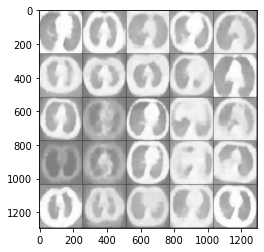

 40%|████      | 80/200 [07:14<10:48,  5.41s/it]

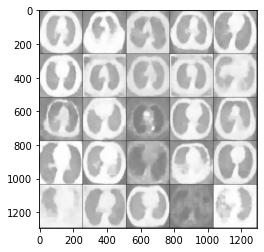

 50%|█████     | 100/200 [09:03<09:01,  5.42s/it]

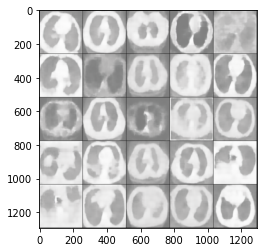

 60%|██████    | 120/200 [10:52<07:15,  5.44s/it]

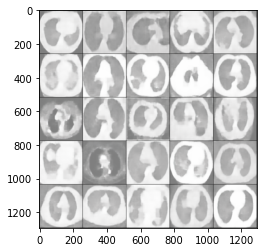

 70%|███████   | 140/200 [12:40<05:24,  5.40s/it]

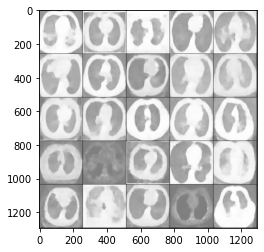

 80%|████████  | 160/200 [14:29<03:35,  5.40s/it]

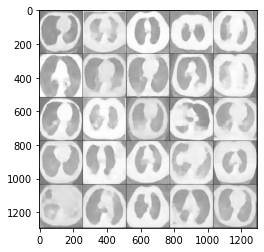

 90%|█████████ | 180/200 [16:17<01:47,  5.38s/it]

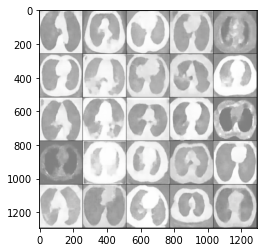

100%|██████████| 200/200 [18:05<00:00,  5.43s/it]

Epoch [200 / 200] average reconstruction error: 5826741.639286


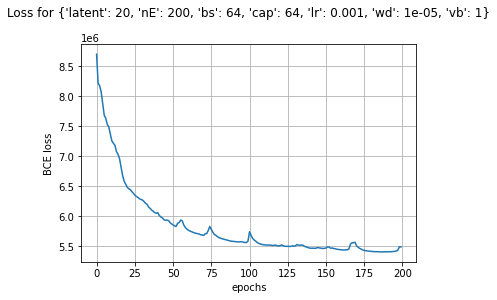

-------------------------------------------------------------------
saving weights for model
-------------------------------------------------------------------

starting run ... 2/4
{'latent': 20, 'nE': 100, 'bs': 64, 'cap': 64, 'lr': 0.001, 'wd': 1e-05, 'vb': 0.5}
cuda
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=32768, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=32768, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=20, out_features=32768,

 10%|█         | 10/100 [00:53<08:04,  5.38s/it]

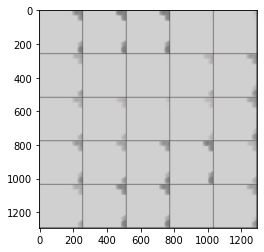

 20%|██        | 20/100 [01:47<07:11,  5.40s/it]

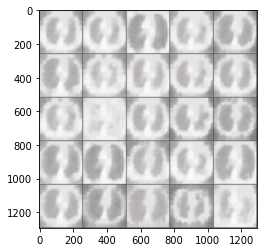

 30%|███       | 30/100 [02:42<06:16,  5.38s/it]

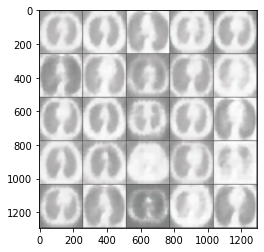

 40%|████      | 40/100 [03:36<05:22,  5.38s/it]

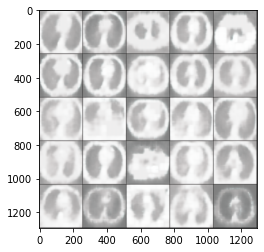

 50%|█████     | 50/100 [04:30<04:29,  5.38s/it]

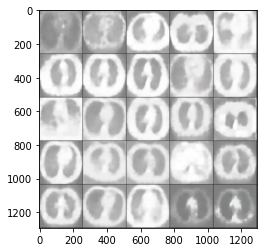

 60%|██████    | 60/100 [05:24<03:35,  5.39s/it]

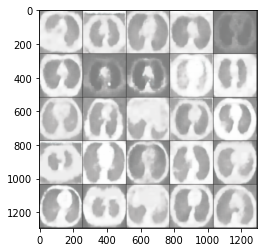

 70%|███████   | 70/100 [06:19<02:43,  5.45s/it]

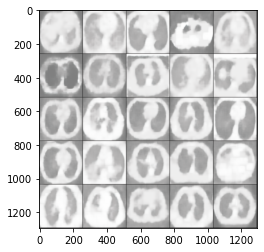

 80%|████████  | 80/100 [07:13<01:47,  5.38s/it]

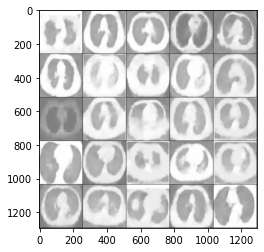

 90%|█████████ | 90/100 [08:07<00:53,  5.38s/it]

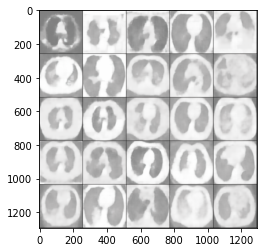

100%|██████████| 100/100 [09:02<00:00,  5.42s/it]

Epoch [100 / 100] average reconstruction error: 6237680.076071


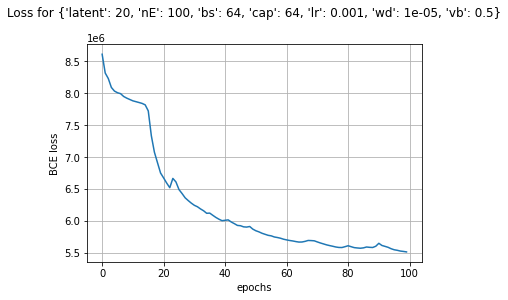

-------------------------------------------------------------------
saving weights for model
-------------------------------------------------------------------

starting run ... 3/4
{'latent': 20, 'nE': 200, 'bs': 64, 'cap': 64, 'lr': 0.001, 'wd': 1e-05, 'vb': 0.5}
cuda
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=32768, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=32768, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=20, out_features=32768,

 10%|█         | 20/200 [01:47<16:15,  5.42s/it]

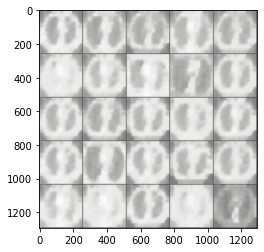

 20%|██        | 40/200 [03:35<14:20,  5.38s/it]

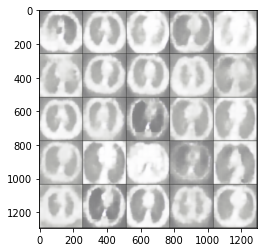

 30%|███       | 60/200 [05:24<12:32,  5.38s/it]

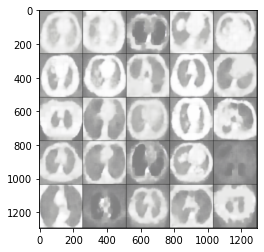

 40%|████      | 80/200 [07:12<10:49,  5.41s/it]

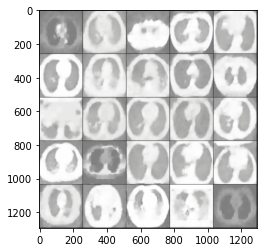

 50%|█████     | 100/200 [09:01<08:59,  5.39s/it]

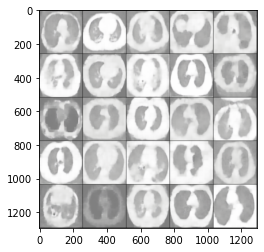

 60%|██████    | 120/200 [10:49<07:13,  5.42s/it]

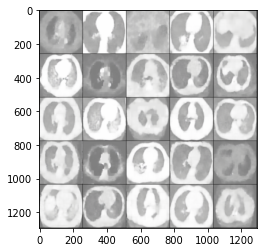

 70%|███████   | 140/200 [12:38<05:24,  5.40s/it]

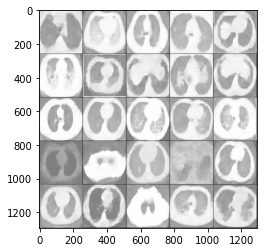

 80%|████████  | 160/200 [14:26<03:36,  5.40s/it]

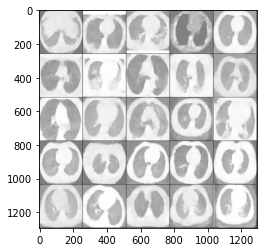

 90%|█████████ | 180/200 [16:15<01:48,  5.41s/it]

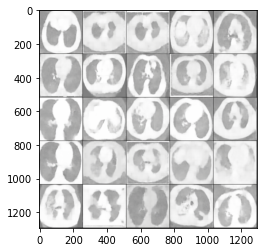

100%|██████████| 200/200 [18:04<00:00,  5.42s/it]

Epoch [200 / 200] average reconstruction error: 5959352.395179


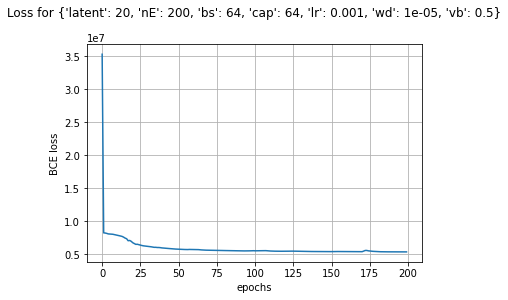

-------------------------------------------------------------------
saving weights for model
-------------------------------------------------------------------



In [ ]:
for k, settings in enumerate(runs):

    print(f"starting run ... {k}/{len(runs)}")
    print(settings)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=settings["bs"], shuffle=True, num_workers=0)

    vae = setup_model(settings["cap"], settings["latent"])

    vae, best_model_wts, bmw_epoch, train_loss = train(vae, train_loader, settings["nE"], settings["lr"], settings["wd"], settings["vb"])
    last_modeL_wts = vae.state_dict()

    plot_loss(train_loss, settings)

    print("-------------------------------------------------------------------")
    print("saving weights for model")

    torch.save(vae.state_dict(), f'n_{settings["nE"]}.ld_{settings["latent"]}.lr_{settings["lr"]}.vb_{settings["vb"]}.last_model.wts')
    vae.load_state_dict(best_model_wts)
    torch.save(vae.state_dict(), f'n_{bmw_epoch}.ld_{settings["latent"]}.lr_{settings["lr"]}.vb_{settings["vb"]}.lowest_loss_model.wts')

    print("-------------------------------------------------------------------")
    print()